In [8]:
import math
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Simple Car class to hold variables

In [15]:
class Car:
    def __init__(self,
                x=256,
                y=256,
                velocity=40,
                surrounding_size=512, 
                orientation='v'):
        self.COREX = int(surrounding_size/2)
        self.COREY = int(surrounding_size/2)
        self.x = x
        self.y = y
        self.orientation = orientation
        
        self.velocity = velocity
        # self.acceleration
        # self.rotation
        
    def getDistance(self):
        return ( (self.x-self.COREX)**2 + (self.y-self.COREY)**2 )**0.5
    
    def draw(self, surrounding, color=255):
        if self.orientation == 'v':
            surrounding[self.y-2:self.y+2, self.x-1:self.x+1] = color
        else:
            surrounding[self.y-1:self.y+1, self.x-2:self.x+2] = color

### Create First Person Car (EgoCar)

In [16]:
surrounding_size = 256   
egoCar = Car(int(surrounding_size/2), int(surrounding_size/2), 40, surrounding_size, orientation='v')
print('Generated car is', egoCar.getDistance(), 'away')

Generated car is 0.0 away


# Generate Cars

In [17]:
surrounding_mid = int(surrounding_size/2)
possible_x = list(range(0, surrounding_mid-2)) + list(range(surrounding_mid+2, surrounding_size))
print("Allowed X:", len(possible_x))

possible_y = list(range(0, surrounding_mid-3)) + list(range(surrounding_mid+3, surrounding_size))
print("Allowed Y:", len(possible_y))

possible_v = list(range(40))

numCars = 30
cars = [Car(random.choice(possible_x), 
            random.choice(possible_y), 
            random.choice(possible_v), 
            surrounding_size, 
            random.choice(['h', 'v'])) for _ in range(numCars)]

print(len(cars), "cars created!")


Allowed X: 252
Allowed Y: 250
30 cars created!


# Display Cars on BEV

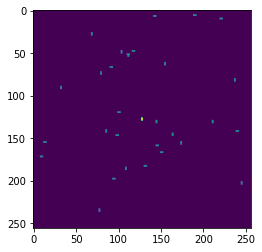

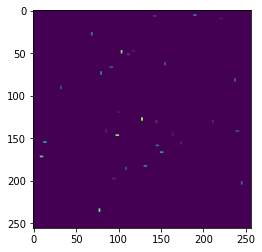

In [21]:
# Blank layout
surrounding = np.zeros((surrounding_size, surrounding_size))
v_surrounding = np.zeros((surrounding_size, surrounding_size))

# Draw EgoCar
egoCar.draw(surrounding)
egoCar.draw(v_surrounding, egoCar.velocity*5)

# Draw other cars
for c in cars: 
    c.draw(surrounding, color=120)
    c.draw(v_surrounding, color=c.velocity*5)

plt.figure()
plt.imshow(surrounding)
plt.show()

plt.figure()
plt.imshow(v_surrounding)
plt.show()

In [37]:
import torch
from torch import nn
from torch.nn.utils import spectral_norm

class CNN(torch.nn.Module):
    def __init__(self, 
                 nc, 
                 nfm, 
                 img_size,
                 out_dim = 1):
        super(CNN, self).__init__()

        exp = int( math.log(img_size)/math.log(2) )

        self.cnn = [spectral_norm(nn.Conv2d(nc, nfm, 4, 2, 1)),
                   nn.ReLU()]

        for i in range(exp-3):
          self.cnn += [spectral_norm(nn.Conv2d( nfm*(2**i) , nfm*( 2**(i+1) ), 4, 2, 1)),
                      nn.ReLU()]

        self.cnn += [spectral_norm(nn.Conv2d( nfm*( 2**(exp-3) ), out_dim, 4, 1, 0)),
                    nn.Sigmoid()]

        self.cnn = nn.Sequential(*self.cnn)

    def forward(self, inputs):
        return self.cnn(inputs)

In [38]:
t_surrounding = torch.Tensor(surrounding).unsqueeze(0)
t_vsurrounding = torch.Tensor(v_surrounding).unsqueeze(0)
sample_input = torch.cat([t_surrounding, t_vsurrounding], axis=0)
print('Stacked Vehicle Properties:', sample_input.shape)

Stacked Vehicle Properties: torch.Size([2, 256, 256])


In [40]:
MEASUREMENTS = 2
NFM = 64
ENC_DIM = 64

myCNN = CNN(MEASUREMENTS, NFM, surrounding_size, ENC_DIM)
myCNN(sample_input.unsqueeze(0)).flatten()

tensor([0.5074, 0.4610, 0.5739, 0.3011, 0.5231, 0.6097, 0.5656, 0.6365, 0.5775,
        0.6070, 0.4182, 0.5050, 0.4004, 0.5243, 0.3860, 0.5732, 0.4573, 0.4447,
        0.4825, 0.5510, 0.4461, 0.5703, 0.5248, 0.4021, 0.4559, 0.5085, 0.5227,
        0.6005, 0.5334, 0.4573, 0.4937, 0.4551, 0.5636, 0.4834, 0.6317, 0.4614,
        0.5071, 0.6380, 0.4880, 0.4839, 0.5357, 0.4449, 0.6005, 0.5517, 0.5336,
        0.5518, 0.5323, 0.5054, 0.4366, 0.4524, 0.4543, 0.3836, 0.5545, 0.6104,
        0.4881, 0.3697, 0.5246, 0.5113, 0.4667, 0.4970, 0.5710, 0.5753, 0.4292,
        0.5142], grad_fn=<ViewBackward>)